In [27]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
from scipy.linalg import sqrtm
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns


In [28]:
M = 6
alpha = 1
strike = 0.045
R = np.array([np.nan,0.03731561,0.04106146,0.04370112,0.04556125,0.04687207])
sigma_market_1b = np.array([0,0,0.041,0.052,0.065,0.083])
sigma_market_1d = np.array([0,0,0.045,0.057,0.073,0.096])

caplet prices: [0.         0.         0.00139536 0.00476539 0.00653331 0.00740222]
cap price: 200.96271265421674.
R_swap_1b: 0.04763270099674098, S_swap_1b: 4.3861317034117775
cap annual premium_1b: 45.8177561102182
cap price: 187.00915205778614.
R_swap_1c: 0.05199950984678004, S_swap_1c: 2.501600942990318
cap annual premium: 74.7557889206112


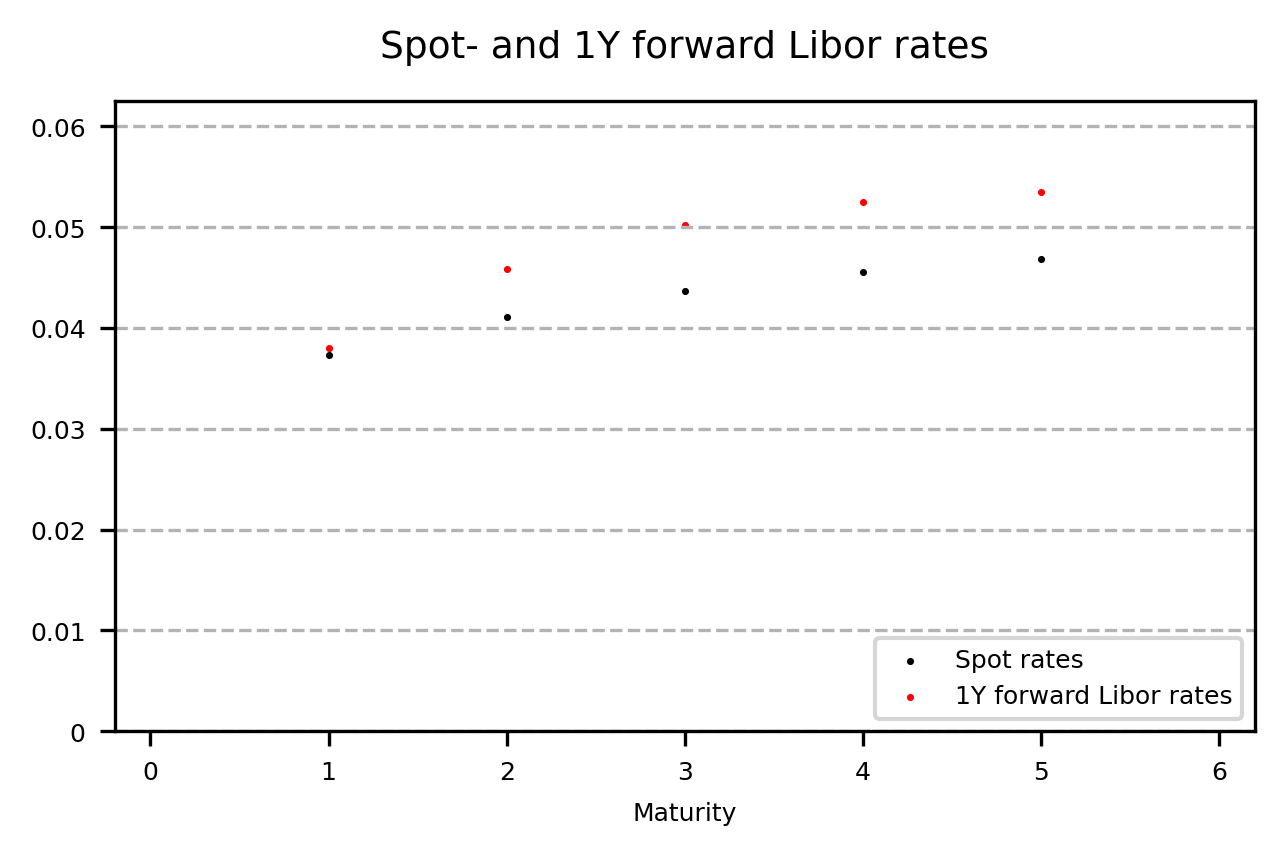

In [29]:
# Problem 1
strike = 0.045
T = np.array([m*alpha for m in range(0,M)])
p = np.ones(M)
L, price_caplet_1, alpha = np.zeros([M]), np.zeros(M), np.zeros(M)
sigma_lmm = np.ones(M)
for i in range(1,M):
    p[i] = np.exp(-R[i]*T[i])
    alpha[i] = T[i]-T[i-1]
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]
    if i > 1:
        price_caplet_1[i] = fid.black_caplet_price(sigma_market_1b[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')
print(f"caplet prices: {price_caplet_1}")
price_cap_1b = sum(price_caplet_1)
print(f"cap price: {price_cap_1b*10000}.")
R_swap_1b, S_swap_1b = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_1b: {R_swap_1b}, S_swap_1b: {S_swap_1b}")
premium_1b = price_cap_1b/S_swap_1b
print(f"cap annual premium_1b: {premium_1b*10000}")
price_cap_1c = sum(price_caplet_1[3:])
print(f"cap price: {price_cap_1c*10000}.")
R_swap_1c, S_swap_1c = fid.swap_rate_from_zcb_prices(0,2,5,"annual",T,p)
print(f"R_swap_1c: {R_swap_1c}, S_swap_1c: {S_swap_1c}")
premium_1c = price_cap_1c/S_swap_1c
print(f"cap annual premium: {premium_1c*10000}")

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Spot- and 1Y forward Libor rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,6]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T[1:], R[1:], s = 2, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], L[1:], s = 2, color = 'red', marker = ".",label="1Y forward Libor rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

In [30]:
# Problem 2
strike = 0.05
price_caplet_2 = np.zeros(M)
for i in range(2,M):
    price_caplet_2[i] = fid.black_caplet_price(sigma_market_1d[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')
print(f"caplet prices: {price_caplet_2}")
price_cap_2b = sum(price_caplet_2)
print(f"cap price: {price_cap_2b*10000}.")
R_swap_2b, S_swap_2b = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_2b: {R_swap_2b}, S_swap_2b: {S_swap_2b}")
premium_2b = price_cap_2b/S_swap_2b
print(f"cap annual premium_2b: {premium_2b*10000}")

caplet prices: [0.         0.         0.00010993 0.00181913 0.00364917 0.00505373]
cap price: 106.31953854258.
R_swap_2b: 0.04763270099674098, S_swap_2b: 4.3861317034117775
cap annual premium_2b: 24.239932982376875


caplet_price for a strike of 0.0475 is [ 5.81098253 26.86399391 54.41048926 66.0337763 ], cap price: 153.11924199352615


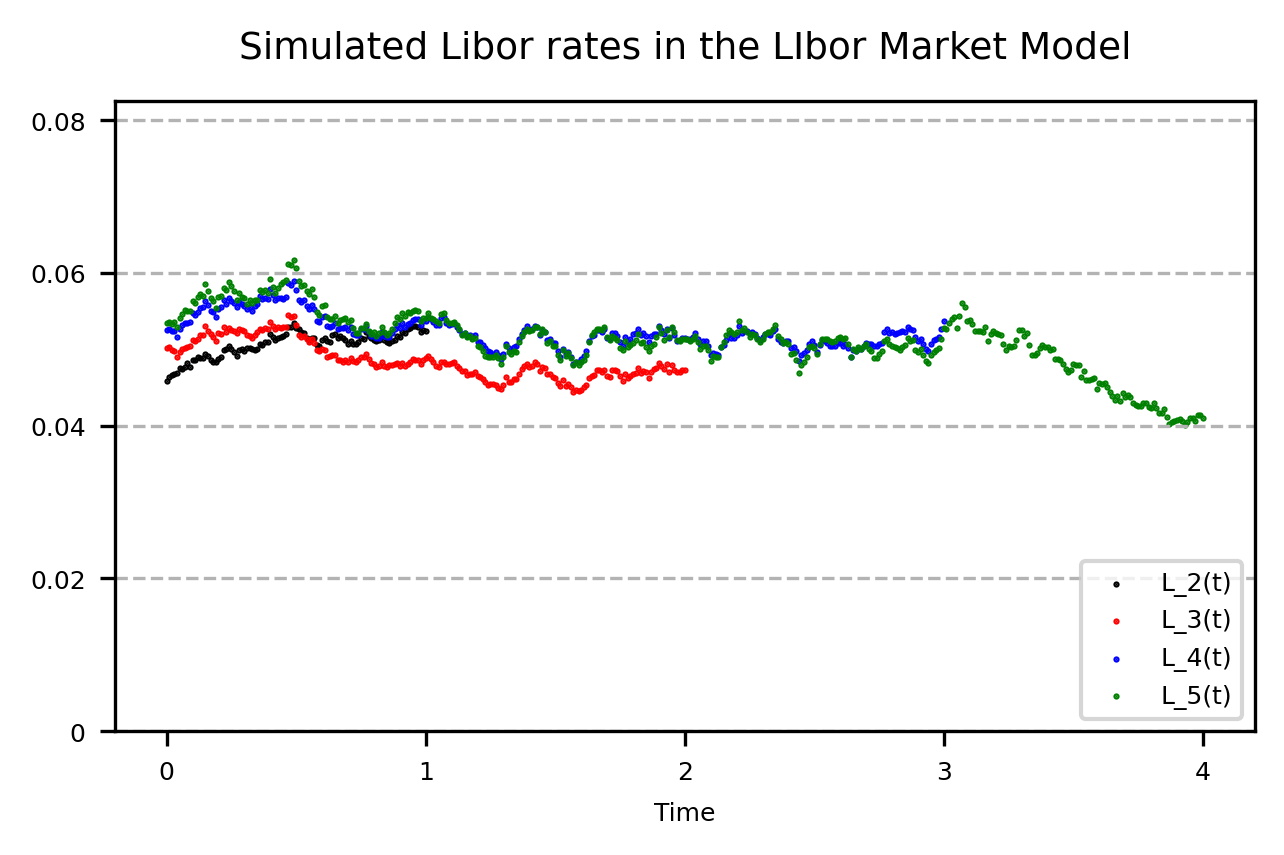

In [32]:
# Problem 3 - Simulation of the Libor market model
M_simul, T_simul = 400, 4
sigma_lmm = np.zeros([M-2])
for i in range(0,M-2):
    sigma_lmm[i] = sigma_market_1b[i+2]*np.sqrt(T[i+2]/T[i+1])
rho = np.array([[1,0.5,0.9,0.85],[0.95,1,0.95,0.9],[0.9,0.95,1,0.95],[0.85,0.9,0.95,1]])
rho_sqrt = sqrtm(rho)
L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,rho,M_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])


strike_lmm = 0.0475
N_simul = 1000
caplet_price_3 = np.zeros(M-2)
chi_disc = np.zeros([M-2,N_simul])
for n in range(0,N_simul):
    L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,rho,M_simul)
    for j in range(0,M-2):
        chi_disc[j,n] = p[-1]*alpha[j+2]*max(L_simul[j,int((j+1)*M_simul/4)] - strike_lmm,0)
        for k in range(j+1,M-2):
            chi_disc[j,n] *= (1+alpha[k+2]*L_simul[k,int((k+1)*M_simul/4)])
for i in range(0,M-2):
    caplet_price_3[i] = sum(chi_disc[i,:])/N_simul*10000
print(f"caplet_price for a strike of {strike_lmm} is {caplet_price_3}, cap price: {sum(caplet_price_3)}")


fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Simulated Libor rates in the LIbor Market Model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,1,2,3,4])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
# ax.set_xlim([xticks[0]+-0.2,2+0.2])
plt.xlabel(f"Time",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(t_simul, L_simul[0,:], s = 1, color = 'black', marker = ".",label="L_2(t)")
p2 = ax.scatter(t_simul, L_simul[1,:], s = 1, color = 'red', marker = ".",label="L_3(t)")
p3 = ax.scatter(t_simul, L_simul[2,:], s = 1, color = 'blue', marker = ".",label="L_4(t)")
p4 = ax.scatter(t_simul, L_simul[3,:], s = 1, color = 'green', marker = ".",label="L_5(t)")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()